# Kalman Filter Pairs Trading



In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint
import yfinance as yf

plt.style.use('seaborn-v0_8-darkgrid')


## 1) Setting the Universe of Stocks

The data is taken fromm January 2018 to January 2025 which can be modified if needed and so can the universe.



In [ ]:


universe = [
    # Technology
    "AAPL", "MSFT", "GOOGL", "META", "NVDA",
    
    # Consumer Discretionary
    "AMZN", "TSLA", "HD", "MCD", "NKE",
    
    # Financials
    "JPM", "BAC", "C", "WFC", "GS",
    
    # Industrials
    "BA", "CAT", "MMM", "GE", "DE",
    
    # Energy
    "XOM", "CVX", "COP", "SLB", "PSX",
    
    # Healthcare
    "JNJ", "PFE", "MRK", "ABBV", "UNH",
    
    # Utilities
    "NEE", "DUK", "SO", "D", "AEP",
    
    # Consumer Staples
    "KO", "PEP", "PG", "WMT", "COST"
]



start = '2018-01-01'
end = '2025-01-01'

        


## 2) Data fetching and Cointegration Checker for Pair Selection

Cointegration is a statistical property where two (or more) non-stationary time series move together in such a way that a linear combination of them is stationary.  

Mathematically, for two price series $x_t$ and $y_t$:

$$
y_t = \alpha + \beta x_t + \epsilon_t
$$

where $\epsilon_t$ is a series such that its mean(=0) , variance and autocorrelation are constant over time.

This matters because if the combination of two stocks is expected to mean-revert , we can trade them in that combination and make profitable trades.  

### Test for Cointegration of a pair:

We use the **Engle-Granger Test** for this, which runs an Ordinary Least Squares regression of one variable in terms of the other, which basically computes $\epsilon_t$ as above in the equation and checks for the stationarity of it. 

This is done by the Augmented Dicky Fuller test for statioanarity and we are returned a p-value. A low p_value (< o.o5) indicates the series are cointegrated and a high p value implies they are not.

### Half-Life :

The half-life is the time it takes for the spread to decay by half towards its long-term mean after a deviation, and thus is an indicatior of the strength of mean reversion.

We compute this by taking the series at hand, computing the first finite difference and taking $-\frac{\ln(2)}{(\beta)}$ , where $\beta$ is the coefficent of linear regression done on the finite difference series with the lagged series itself .

This will help us to estimate a moving avergae window later for z-score computation.









In [ ]:
def fetch_prices(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, progress=False)
    if 'Adj Close' in data:
        prices = data['Adj Close']
    elif 'Close' in data:
        prices = data['Close']
    else:
        prices = data
    if isinstance(prices, pd.Series):
        prices = prices.to_frame()
    prices = prices.dropna(how='all')
    return prices


def find_best_cointegrated_pair(price_df, pvalue_thresh=0.05, top_n=1):
    import itertools
    results = []
    tickers = price_df.columns.tolist()
    for a, b in itertools.combinations(tickers, 2):
        s1 = price_df[a].dropna()
        s2 = price_df[b].dropna()
        df = pd.concat([s1, s2], axis=1).dropna()
        if len(df) < min_obs_for_test:
            continue
        score, pvalue, _ = coint(df.iloc[:,0], df.iloc[:,1])
        results.append((a, b, pvalue))
    results = sorted(results, key=lambda x: x[2])
    return results[:top_n]

#the top 10 most cointegrated pairs sorted by the p value from the above test stored in top pairs.
top_pairs = find_best_cointegrated_pair(prices_all, top_n=10)
print("Top 10 cointegrated pairs:", [(a,b) for a,b,_ in top_pairs])




def half_life(spread):
    s = spread.dropna().values
    if len(s) < 10:
        return 60
    lag = s[:-1]
    delta = s[1:] - s[:-1]
    beta = np.polyfit(lag, delta, 1)[0]
    if beta >= 0:
        return 60
    hl = -np.log(2) / beta
    hl = int(np.round(hl))
   
    return max(10,min(120,hl))


Top 10 cointegrated pairs: [('KO', 'SO'), ('DUK', 'KO'), ('BA', 'JNJ'), ('AEP', 'KO'), ('BA', 'NEE'), ('GE', 'NVDA'), ('GOOGL', 'HD'), ('KO', 'UNH'), ('JNJ', 'NEE'), ('HD', 'PG')]


## 3) Selecting Desirable Pairs to Trade on

We work initially with the pair with the lowest p-value for a detailed analysis and later generalise to multiple pairs stored in top_pairs.

In [ ]:

prices_all = fetch_prices(universe, start, end)
best = top_pairs
if len(best) == 0:
    raise RuntimeError('No cointegrated pairs found in universe')
pair = [best[0][0], best[0][1]]
prices = prices_all[pair]

print('Selected pair:', pair)
prices = prices.dropna()
prices.head()

# we proceed with the most cointegrated pair for now which is Coca-Cola and Southern Comapny for now.

Selected pair: ['KO', 'SO']


Ticker,KO,SO
Date,,
2018-01-02,35.742027,33.953892
2018-01-03,35.663551,33.759541
2018-01-04,36.165848,33.615578
2018-01-05,36.158001,33.673176
2018-01-08,36.103062,33.975483


## 4. Kalman Filter Estimation of Dynamic α and β 

In pairs trading, the linear relationship between two cointegrated assets may change over time. To capture this, we model the prices using a **time-varying regression**:

$$
y_t = \alpha_t + \beta_t x_t + \epsilon_t
$$

where $y_t$ is the price of the second asset, $x_t$ is the price of the first asset, $\alpha_t$ is a time-varying intercept, $\beta_t$ is a time-varying slope, and $\epsilon_t$ is observation noise, assumed to be Gaussian with variance $R$.

The Kalman filter treats $\alpha_t$ and $\beta_t$ as **latent states** collected in the vector

$$
\mathbf{\theta}_t = 
\begin{bmatrix} \beta_t \\ \alpha_t \end{bmatrix}
$$

and assumes they evolve according to a **state equation**:

$$
\mathbf{\theta}_t = \mathbf{\theta}_{t-1} + w_t
$$

Here, $w_t$ is the **process noise**, a Gaussian vector with covariance matrix $Q$. This term represents our uncertainty about how much $\alpha$ and $\beta$ can drift between periods. A small $Q$ implies the model assumes the relationship is almost static, while a larger $Q$ allows α and β to adapt more quickly to changing market conditions.

At each time step, the Kalman filter performs two key updates: a **prediction step** and a **correction (update) step**.  

In the **prediction step**, the filter estimates the next state based on the previous state:

$$
\hat{\mathbf{\theta}}_{t|t-1} = \hat{\mathbf{\theta}}_{t-1|t-1}
$$

and predicts the associated covariance:

$$
P_{t|t-1} = P_{t-1|t-1} + Q
$$

where $P$ represents the uncertainty about the state estimates.

In the **correction step**, the filter adjusts the predicted state using the observed price $y_t$. The innovation (difference between the observed $y_t$ and the predicted observation) is:

$$
\nu_t = y_t - H_t \hat{\mathbf{\theta}}_{t|t-1}, \quad H_t = [x_t \quad 1]
$$

The Kalman gain, which determines how much we trust the new observation relative to the prior estimate, is computed as:

$$
K_t = P_{t|t-1} H_t^\top (H_t P_{t|t-1} H_t^\top + R)^{-1}
$$

The state estimate is updated as:

$$
\hat{\mathbf{\theta}}_{t|t} = \hat{\mathbf{\theta}}_{t|t-1} + K_t \nu_t
$$

and the covariance is updated accordingly:

$$
P_{t|t} = (I - K_t H_t) P_{t|t-1}
$$

Through these recursive steps, the Kalman filter continuously adapts $\alpha_t$ and $\beta_t$ as new prices arrive, balancing between the prior expectation and the latest observation. This yields a dynamic hedge ratio that can adjust to slow drifts or structural changes in the relationship between the two assets.





In [136]:
def kalman_estimate(y, x, delta=1e-4, obs_var=None, init_state_mean=None):
    y = np.asarray(y).astype(float)
    x = np.asarray(x).astype(float)
    T = len(y)
    obs_mat = np.expand_dims(np.vstack([x, np.ones(T)]).T, axis=1)

    trans_cov = (delta / (1.0 - delta)) * np.eye(2)

    if init_state_mean is None:
        init_state_mean = np.zeros(2)

    if obs_var is None:
        A = np.vstack([np.ones(T), x]).T
        ols_b, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
        res = y - (ols_b[0] + ols_b[1] * x)
        obs_var = max(1e-6, np.nanmedian(res**2))

    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        initial_state_mean=init_state_mean,
        initial_state_covariance=np.eye(2),
        transition_covariance=trans_cov,
        observation_covariance=obs_var,
    )

    state_means, state_covs = kf.filter(y)
    return state_means, state_covs

x = prices.iloc[:,0]
y = prices.iloc[:,1]
state_means, state_covs = kalman_estimate(y.values, x.values, delta=delta)


beta_kf = pd.Series(state_means[:,0], index=prices.index)
alpha_kf = pd.Series(state_means[:,1], index=prices.index)




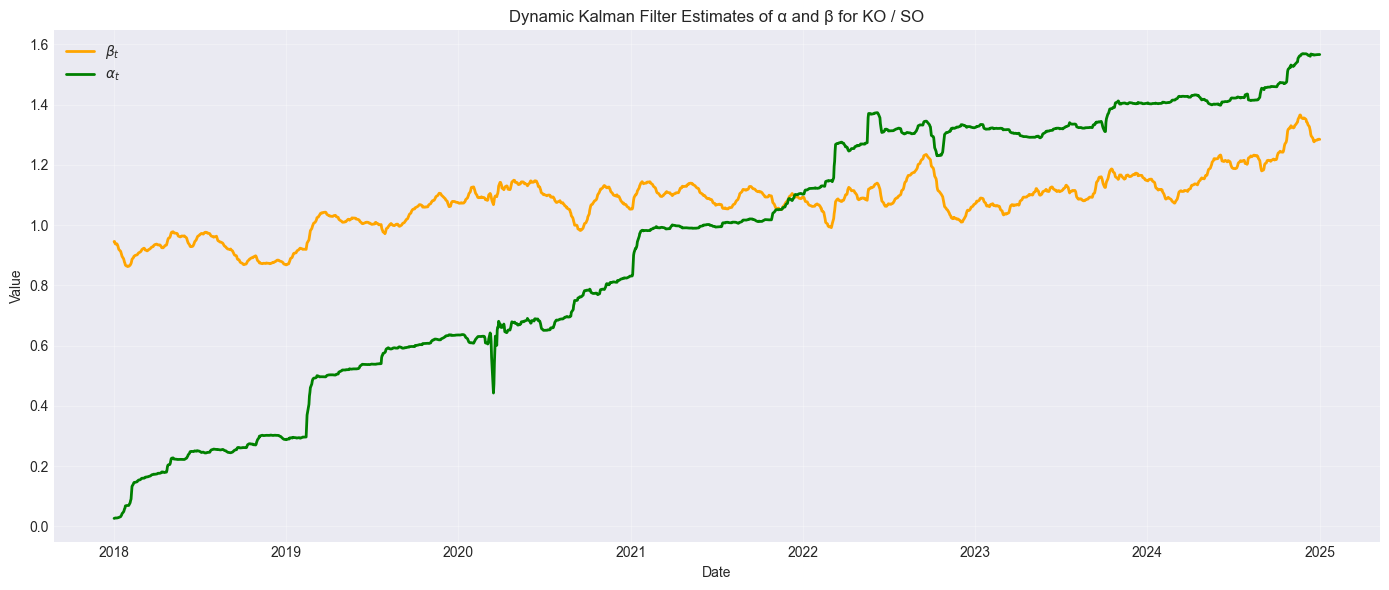

In [137]:
plt.figure(figsize=(14,6))

# Plot beta
plt.plot(beta_kf.index, beta_kf, color='orange', linewidth=2, label=r'$\beta_t$')

# Plot alpha
plt.plot(alpha_kf.index, alpha_kf, color='green', linewidth=2, label=r'$\alpha_t$')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Dynamic Kalman Filter Estimates of α and β for {pair[0]} / {pair[1]}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 5) Spread & Rolling Z-Score for the Signals

Once the dynamic α and β have been estimated using the Kalman filter, the **spread** between the two assets is computed as:

$$
s_t = y_t - (\alpha_t + \beta_t x_t)
$$

This spread represents the deviation of the second asset's price from its predicted value based on the first asset and the current hedge ratio. 
Using the half-life, we define a **rolling window** to compute a partial mean and standard deviation of the spread:

$$
\bar{s}_t = \text{rolling mean of } s_t \text{ over the window}
$$

$$
\sigma_t = \text{rolling standard deviation of } s_t \text{ over the window}
$$

The **z-score** is then calculated as:

$$
z_t = \frac{s_t - \bar{s}_t}{\sigma_t}
$$

This z-score standardizes the spread, allowing us to measure deviations in units of standard deviations from the rolling mean. Large positive or negative values indicate that the spread is significantly away from its expected value, which can trigger trading signals.  

In the code, we store these z-scores in a DataFrame called `signals`, which will later be used to generate entry and exit points for the strategy.



In [147]:
spread = y - (alpha_kf + beta_kf * x)
hl = half_life(spread)
window =min(max( (int)(1.5*hl),20 ),100)
print('Estimated half-life (rolling window):', window)

spread_mean = spread.rolling(window).mean()
spread_std = spread.rolling(window).std()
zscore = (spread - spread_mean) / spread_std


signals = pd.DataFrame({'zscore': zscore})

signals.tail()


Estimated half-life (rolling window): 20


,zscore
Date,
2024-12-24,1.029733
2024-12-26,1.021310
2024-12-27,1.441336
2024-12-30,1.054374
2024-12-31,0.621183


## 6) Backtest

Once the z-scores of the spread have been computed, we implement a backtesting framework to evaluate the strategy's performance. The backtest simulates trading over the historical period by generating long and short positions based on the z-score thresholds.

For a given pair of assets, we define long entry when the z-score falls below a negative threshold (`entryZscore`). This indicates that the spread is significantly below its rolling mean, so we buy the undervalued asset (long). Conversely, we define short entry when the z-score exceeds a positive threshold, signaling that the spread is unusually high.

Positions are closed when the z-score crosses back through the exit threshold (`exitZscore`), which is closer to zero. This ensures that trades are exited once the spread has reverted toward its mean.

The net position at any time is the sum of long and short positions. For each day, we calculate the mark-to-market profit and loss (PnL) as the change in the spread multiplied by the current position size. Transaction costs can be deducted whenever a position changes, though in the default example we set this to zero.

To normalize performance, the daily return is computed as the PnL divided by the notional capital at risk, which accounts for the magnitude of positions in both assets. The cumulative return is then calculated by compounding daily returns.

Finally, a Sharpe ratio is computed to measure risk-adjusted performance, using the mean and standard deviation of daily returns, annualized by the trading frequency (`freq`). Total PnL and cumulative returns provide a direct view of profitability, while the Sharpe ratio allows comparison of risk-adjusted performance across different pairs or parameter settings.




In [ ]:
def backtest(signals, alpha, beta, x, y, cost_per_trade=0.0, notional=1.0, freq=252,entryZscore=2,exitZscore=0.5):
  
    df = pd.DataFrame({'x': x, 'y': y, 'alpha': alpha, 'beta': beta}, index=signals.index)
    df['spread'] = y - (alpha + beta * x)

    
    

    # Long positions
    df['long_entry'] = (signals['zscore'] < -entryZscore) & (signals['zscore'].shift(1) > -entryZscore)
    df['long_exit'] = (signals['zscore'] > -exitZscore) & (signals['zscore'].shift(1) < -exitZscore)
    df['num_units_long'] = np.nan
    df.loc[df['long_entry'], 'num_units_long'] = 1
    df.loc[df['long_exit'], 'num_units_long'] = 0
    df['num_units_long'].iloc[0] = 0
    df['num_units_long'] = df['num_units_long'].fillna(method='ffill')

    # Short positions
    df['short_entry'] = (signals['zscore'] > entryZscore) & (signals['zscore'].shift(1) < entryZscore)
    df['short_exit'] = (signals['zscore'] < exitZscore) & (signals['zscore'].shift(1) > exitZscore)
    df['num_units_short'] = np.nan
    df.loc[df['short_entry'], 'num_units_short'] = -1
    df.loc[df['short_exit'], 'num_units_short'] = 0
    df['num_units_short'].iloc[0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='ffill')

    # Net position
    df['position'] = df['num_units_long'].fillna(0) + df['num_units_short'].fillna(0)

    # Compute daily PnL
    df['pnl'] = 0.0
    df['daily_return']=0.0
    spread_vals = df['spread'].values
    pos_vals = df['position'].values
    for t in range(1, len(df)):
        df.at[df.index[t], 'pnl'] = (spread_vals[t] - spread_vals[t-1]) * pos_vals[t-1] * notional
        if pos_vals[t] != pos_vals[t-1]:
            df.at[df.index[t], 'pnl'] -= cost_per_trade
    
     # Capital for return calculation
        if pos_vals[t-1] != 0:
            capital = abs(pos_vals[t-1]) * ((x.iloc[t-1] *abs( beta.iloc[t-1])) + (y.iloc[t-1]))
            df.at[df.index[t], 'daily_return'] = df.at[df.index[t], 'pnl'] / capital
        else:
            df.at[df.index[t], 'daily_return'] = 0.0
   
    df['cumulative_return'] = (1 + df['daily_return']).cumprod()
    
    # Sharpe ratio
 
    sharpe = (df['daily_return'].mean() / (df['daily_return'].std() + 1e-9)) * np.sqrt(freq) if len(df['daily_return']) > 1 else np.nan
     
    total_pnl = df['pnl'].sum()
    return df, total_pnl, sharpe
  

# Example usage:
bt_df, total_pnl, sharpe = backtest(signals, alpha_kf, beta_kf, x, y, cost_per_trade=0.0, notional=1.0)
print('Total PnL:', total_pnl)
print('Sharpe:', sharpe)



Total PnL: 84.66277454452334
Sharpe: 2.417787997884122


## Tuning Exit/Entry Thresholds 

Here we use 70% of the data at hand to compute the sharpe ratio for a number of possible pairs of entry and exit thresholds, and choosing the thresholds with the maximum sharpe as the candidate for testing. These parameters can also be chosen by some other mathematical combination of paramteters such as fitness or a linear combination of such metrics but for simplicity we use Sharpe. More elaboration on the metrtics is given belwo.

Some constraints are there to rule out pairs that practically dont make as much sense to avoid overfit and reduce search space. Here the exit threshold should not be very close to zero (>=0.4) and there must be a sufficicent bandwith between the entry and exit threshlods.

Among other tunable parameters , mainly the rolling window and the delta for the Kalman filter, we fix the delta for Kalman (it leads to overfit if not checked mutliple times and does not improve the results much) and use half life as said above .



In [ ]:

import itertools

entry_grid = np.arange(0.7, 2.5, 0.1)  # 1.0 to 3.0
exit_grid  = np.arange(-0.2, 0.6, 0.1)   # 0.1 to 1.0

best_sharpe = -np.inf
best_entry, best_exit = None, None
n = len(signals)
split_idx = int(np.floor(n * 0.7))
train_idx = signals.index[:split_idx]
test_idx = signals.index[split_idx:]

#splitting all the series for training (70%)
signals_train = signals.loc[train_idx]
alpha_train = alpha_kf.loc[train_idx]
beta_train = beta_kf.loc[train_idx]
x_train = x.loc[train_idx]
y_train = y.loc[train_idx]

#splitting the series for testing (30%)
signals_test=signals.loc[test_idx]
alpha_test=alpha_kf.loc[test_idx]
beta_test=beta_kf.loc[test_idx]
x_test=x.loc[test_idx]  
y_test=y.loc[test_idx]     


for e, f in itertools.product(entry_grid, exit_grid):
    if (f >= e or (e-f<0.8) or f<0.4):  # exit should be smaller than entry
        continue
    _, _, sharpe = backtest(signals_train, alpha_train, beta_train, x_train, y_train,cost_per_trade=0.0, notional=1.0, freq=252, entryZscore=e, exitZscore=f)
    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_entry, best_exit = e, f

print("Optimal thresholds found:")
print("Entry z-score:", best_entry)
print("Exit z-score:", best_exit)





Optimal thresholds found:
Entry z-score: 1.2999999999999998
Exit z-score: 0.4000000000000001
Sharpe: 2.690588324750045


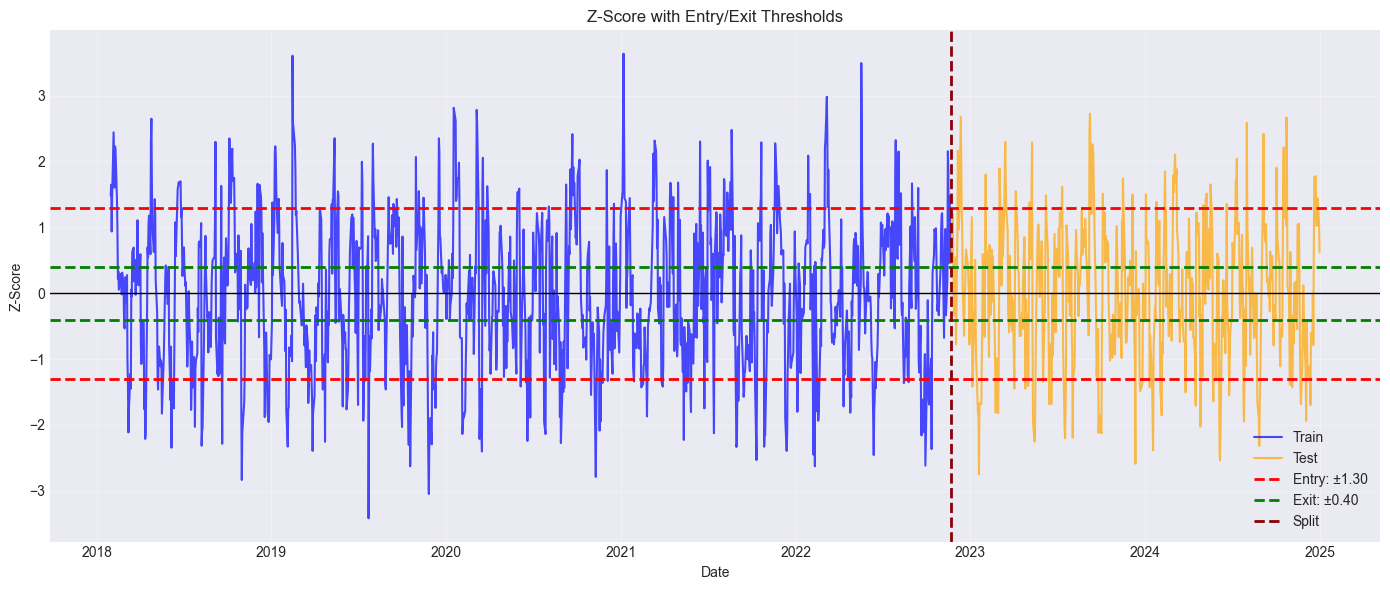

In [109]:
# Simple z-score plot with train/test colors
plt.figure(figsize=(14, 6))

# Plot z-scores in different colors
plt.plot(signals.loc[train_idx].index, signals.loc[train_idx, 'zscore'], 
         color='blue', linewidth=1.5, alpha=0.7, label='Train')
plt.plot(signals.loc[test_idx].index, signals.loc[test_idx, 'zscore'], 
         color='orange', linewidth=1.5, alpha=0.7, label='Test')

# Threshold lines
plt.axhline(best_entry, color='red', linestyle='--', linewidth=2, label=f'Entry: ±{best_entry:.2f}')
plt.axhline(-best_entry, color='red', linestyle='--', linewidth=2)
plt.axhline(best_exit, color='green', linestyle='--', linewidth=2, label=f'Exit: ±{best_exit:.2f}')
plt.axhline(-best_exit, color='green', linestyle='--', linewidth=2)
plt.axhline(0, color='black', linestyle='-', linewidth=1)

# Split line
split_date = signals.index[split_idx]
plt.axvline(split_date, color='darkred', linestyle='--', linewidth=2, label='Split')

plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.title('Z-Score with Entry/Exit Thresholds')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7) Performance Metrics 

After backtesting the pairs trading strategy, it is important to quantify its performance using a variety of financial and statistical metrics. The `compute_full_metrics` function calculates a comprehensive set of metrics to evaluate both profitability and risk.

**Cumulative Return and CAGR**  
The cumulative return measures the total growth of the strategy over the period. The **Compound Annual Growth Rate (CAGR)** normalizes the total return by time, providing an annualized measure of performance.

**Risk-Adjusted Metrics: Sharpe and Sortino Ratios**  
The **Sharpe ratio**(calulated before as well) is calculated as the mean daily return divided by the daily standard deviation, annualized by the trading frequency. It quantifies the return per unit of total risk.  
The **Sortino ratio** is similar, but only considers downside volatility, penalizing negative returns while ignoring upside variability.

**Drawdown Analysis**  
Drawdowns measure the decline from a historical peak in cumulative returns. Maximum drawdown captures the largest peak-to-trough drop, while **drawdown duration** measures how long the strategy stays underwater. These metrics provide insight into potential capital at risk.

**Win/Loss Statistics**  
 Win rate indicates the proportion of profitable days.  
Average win and average loss measure typical gains and losses per trade.  
Payoff ratio is the ratio of average win to average loss, summarizing the reward-to-risk per trade.

**Exposure and Trades**  
Exposure measures the fraction of time the strategy is actively holding positions.  
Number of trades counts how many times positions change, giving insight into trading activity and potential transaction costs.

**Higher-Order Statistics**  
Higher moments such as **skewness** and **kurtosis** describe the distribution of daily returns.  
The **Omega ratio** compares gains versus losses above/below a threshold (usually zero).  
**Value at Risk (VaR 95%)** and **Conditional VaR (CVaR 95%)** estimate potential losses under extreme scenarios.

**Fitness Metrics**  
 combine profitability, risk, and win/loss characteristics into a single score to compare strategies. For example, one fitness metric multiplies Sharpe, win rate, and payoff ratio while penalizing large drawdowns.

 This allows us to do meaningful comparisons between different pairs or parameter choicesin different periods of time.


In [ ]:
def compute_full_metrics(bt_df, freq=252):
    df = bt_df.copy()
    rets = df['daily_return'].replace([np.inf, -np.inf], np.nan).dropna()
    if len(rets) == 0:
        raise ValueError("No valid daily returns in dataframe")

    # cumulative return and total
    df['cumulative_return'] = (1 + df['daily_return']).cumprod()
    total_return = df['cumulative_return'].iloc[-1] - 1

    # time in years
    years = len(df) / freq if freq>0 else np.nan
    cagr = (1 + total_return)**(1/years) - 1 if years > 0 else np.nan

    # Sharpe and vol (annualized vol included)
    mean_ret = rets.mean()
    vol_daily = rets.std()
    vol_annual = vol_daily * np.sqrt(freq)
    sharpe = mean_ret / (vol_daily + 1e-12) * np.sqrt(freq)

    # Sortino
    downside = rets[rets < 0].std()
    sortino = mean_ret / (downside + 1e-12) * np.sqrt(freq)

    # Drawdown
    cum = df['cumulative_return']
    running_max = cum.cummax()
    drawdown = (cum - running_max) / running_max
    max_dd = drawdown.min()
    # drawdown duration
    dd_durations = []
    dur = 0
    for i in range(len(drawdown)):
        if drawdown.iloc[i] < 0:
            dur += 1
        else:
            if dur > 0:
                dd_durations.append(dur)
            dur = 0
    max_dd_duration = max(dd_durations) if dd_durations else 0

    # wins/losses
    wins = (rets > 0).sum()
    losses = (rets < 0).sum()
    win_rate = wins / (wins + losses + 1e-12)
    avg_win = rets[rets > 0].mean() if wins > 0 else 0.0
    avg_loss = rets[rets < 0].mean() if losses > 0 else 0.0
    payoff = abs(avg_win / (avg_loss + 1e-12)) if (avg_loss != 0) else np.nan

    # exposure & trades
    exposure = (df['position'] != 0).mean()
    num_trades = (df['position'].shift(1) != df['position']).sum()

    # skew/kurt/omega/var/cvar
    skewness = rets.skew()
    kurt = rets.kurtosis()
    threshold = 0.0
    omega = (rets[rets > threshold].sum()) / abs(rets[rets < threshold].sum() + 1e-12)
    var_95 = np.percentile(rets, 5)
    cvar_95 = rets[rets <= var_95].mean()

    # fitness 
    fitness = sharpe * win_rate * (payoff if not np.isnan(payoff) else 1.0)
    
    #

    metrics = {
        "Total Return": total_return,
        "CAGR": cagr,
        "Sharpe": sharpe,
        "Sortino": sortino,
        "Calmar": cagr / (abs(max_dd) + 1e-12),
         "Fitness ": fitness,
        "MAR Ratio": (mean_ret * freq) / (abs(max_dd) + 1e-12),
        "Volatility (daily)": vol_daily,
        "Volatility (annual)": vol_annual,
        "Max Drawdown": max_dd,
        "Max Drawdown Duration (days)": max_dd_duration,
        "Win Rate": win_rate,
        "Average Win": avg_win,
        "Average Loss": avg_loss,
        "Payoff Ratio": payoff,
        "Exposure %": exposure * 100,
        "Num Trades": num_trades,
        "Skew": skewness,
        "Kurtosis": kurt,
        "Omega Ratio": omega,
        "VaR 95%": var_95,
        
        
    }
    return metrics



Lets evaluate the metrics on signals using the default 2.0 entry and 0.5 exit with the optimum ones found by grid search.

In [ ]:

# A signal with the default exit and entry parameters
bt_default, _, _ = backtest(
    signals, alpha_kf, beta_kf, x, y,
    entryZscore=2.0, exitZscore=0.5
)

# 2. Optimized entry and exit parameters
bt_optimized, _, _ = backtest(
    signals, alpha_kf, beta_kf, x, y,
    entryZscore=best_entry, exitZscore=best_exit
)

# Compute metrics for both
metrics_default = compute_full_metrics(bt_default)
metrics_optimized = compute_full_metrics(bt_optimized)

comparison = pd.DataFrame({
    'Default (2.0/0.5)': metrics_default,
    f'Optimized ({best_entry:.1f}/{best_exit:.1f})': metrics_optimized
})

comparison

,Default (2.0/0.5),Optimized (1.3/0.4)
Total Return,1.302550,2.379316
CAGR,0.126762,0.190353
Sharpe,2.417789,2.907190
Sortino,2.102599,3.430864
Calmar,5.685497,6.501123
MAR Ratio,5.409244,6.015244
Volatility (daily),0.003142,0.003816
Volatility (annual),0.049882,0.060583
Max Drawdown,-0.022296,-0.029280
Max Drawdown Duration (days),36.000000,52.000000


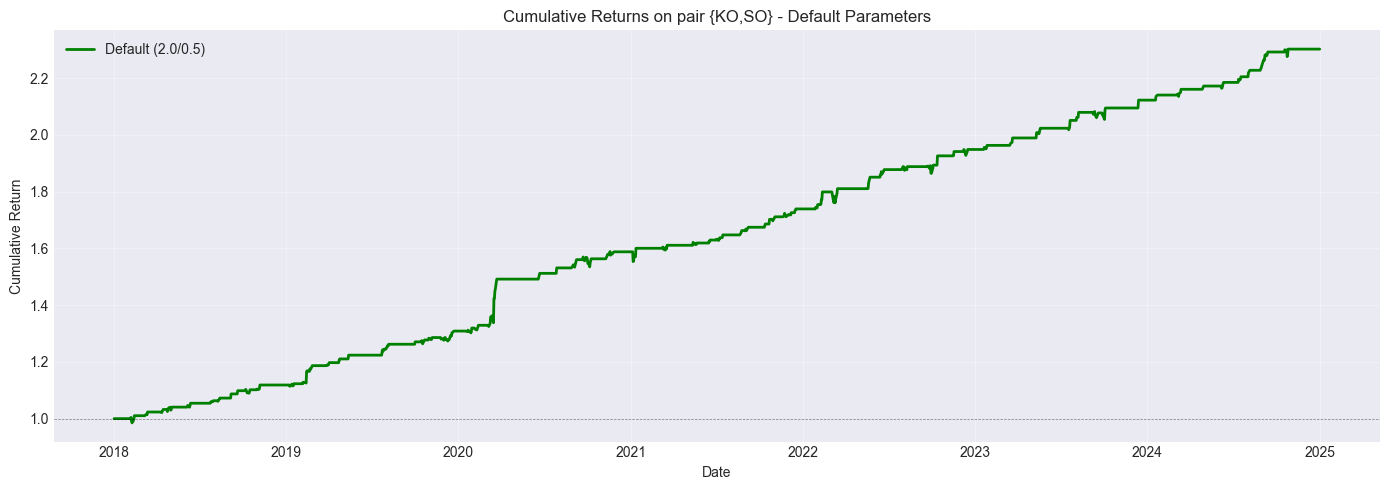

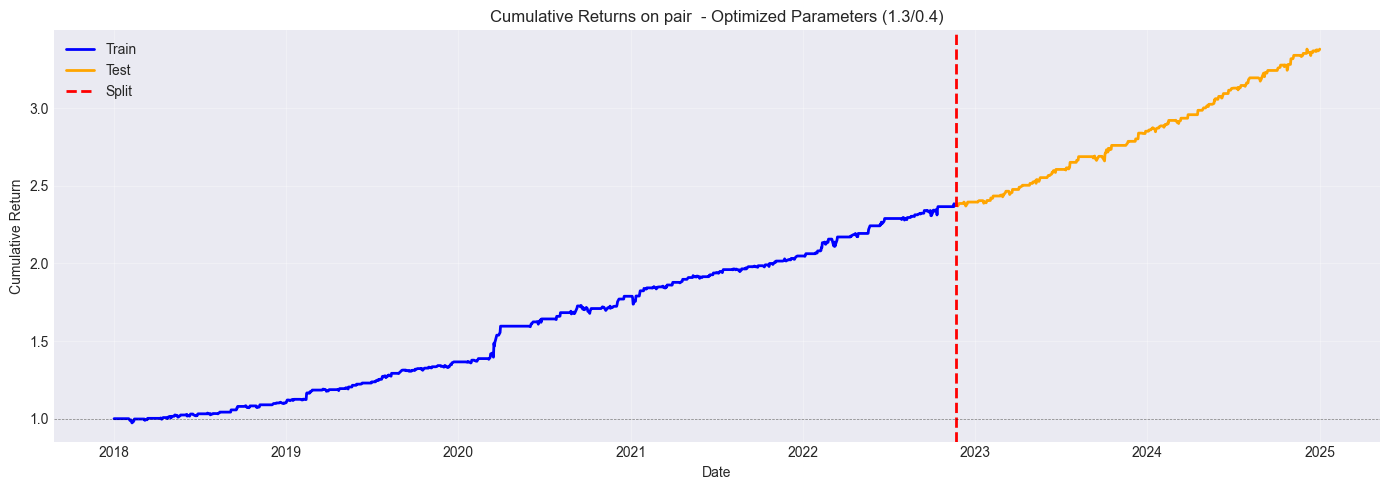

In [ ]:
# Plot 1: Default parameters PnL
plt.figure(figsize=(14, 5))
plt.plot(bt_default.index, bt_default['cumulative_return'], 
         color='green', linewidth=2, label='Default (2.0/0.5)')
plt.axhline(1.0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns on pair {KO,SO} - Default Parameters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Optimized parameters with train/test coloring
plt.figure(figsize=(14, 5))
split_date = signals.index[split_idx]

# Plot train portion
plt.plot(bt_optimized[bt_optimized.index < split_date].index, 
         bt_optimized[bt_optimized.index < split_date]['cumulative_return'], 
         color='blue', linewidth=2, label='Train')

# Plot test portion
plt.plot(bt_optimized[bt_optimized.index >= split_date].index, 
         bt_optimized[bt_optimized.index >= split_date]['cumulative_return'], 
         color='orange', linewidth=2, label='Test')

plt.axvline(split_date, color='red', linestyle='--', linewidth=2, label='Split')
plt.axhline(1.0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title(f'Cumulative Returns - Optimized Parameters ({best_entry:.1f}/{best_exit:.1f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Combining all of the above to create a function that does this for any arbitrary pair.

In [ ]:
def run_pair_pipeline(pair, start, end, delta=1e-4, entry_grid=None, exit_grid=None,
                      train_frac=0.7, cost_per_trade=0.0, notional=1.0, freq=252,
                      min_exit_gap=0.8, min_window=20):
   
    if entry_grid is None:
        entry_grid = np.arange(0.7, 2.5, 0.1)
    if exit_grid is None:
        exit_grid = np.arange(-0.2, 0.6, 0.1)

    # 1) fetch
    prices = fetch_prices(pair, start, end)
    if prices.shape[1] < 2:
        raise RuntimeError("Not enough price columns for pair: " + str(pair))
    x = prices.iloc[:,0]
    y = prices.iloc[:,1]

    # 2) kalman
    state_means, _ = kalman_estimate(y.values, x.values, delta=delta)
    beta = pd.Series(state_means[:,0], index=prices.index)
    alpha = pd.Series(state_means[:,1], index=prices.index)

    # 3) spread & zscore
    spread = y - (alpha + beta * x)
    hl = half_life(spread)
    window = int(min(max(1.5*hl, min_window), 100))
    spread_mean = spread.rolling(window).mean()
    spread_std = spread.rolling(window).std()
    zscore = (spread - spread_mean) / spread_std
    signals = pd.DataFrame({'zscore': zscore}, index=prices.index)

    # 4) split train/test by index (time)
    n = len(signals)
    split_idx = int(np.floor(n * train_frac))
    train_idx = signals.index[:split_idx]
    test_idx = signals.index[split_idx:]

    signals_train = signals.loc[train_idx]
    alpha_train = alpha.loc[train_idx]
    beta_train = beta.loc[train_idx]
    x_train = x.loc[train_idx]
    y_train = y.loc[train_idx]

    signals_test = signals.loc[test_idx]
    alpha_test = alpha.loc[test_idx]
    beta_test = beta.loc[test_idx]
    x_test = x.loc[test_idx]
    y_test = y.loc[test_idx]

    # 5) tune entry/exit on train
    best_sharpe = -np.inf
    best_entry = None
    best_exit = None
    for e, f in itertools.product(entry_grid, exit_grid):
        if (f >= e) or ((e - f) < min_exit_gap) or (f < 0.0):
            continue
        _, _, s = backtest(signals_train, alpha_train, beta_train, x_train, y_train,
                           cost_per_trade=cost_per_trade, notional=notional, freq=freq,
                           entryZscore=e, exitZscore=f)
        if np.isnan(s):
            continue
        if s > best_sharpe:
            best_sharpe = s
            best_entry, best_exit = e, f

    if best_entry is None:
        raise RuntimeError("No valid thresholds found in grid search on training set")

    # 6) backtest on the test data and the entire dataset
   
    bt_test, _, _ = backtest(signals_test, alpha_test, beta_test, x_test, y_test,
                                              cost_per_trade=cost_per_trade, notional=notional, freq=freq,
                                              entryZscore=best_entry, exitZscore=best_exit)
    bt,_,_ =backtest(signals, alpha, beta,x ,y ,cost_per_trade=cost_per_trade, notional=notional, freq=freq, entryZscore=best_entry, exitZscore=best_exit)
                                                
    # 7) compute metrics
    metrics_test = compute_full_metrics(bt_test, freq=freq)
    metrics_full=compute_full_metrics(bt,freq=freq)
    results = {
        'pair': pair,
        'delta': delta,
        'best_entry': best_entry,
        'best_exit': best_exit,
        'best_sharpe_train': best_sharpe,
        'bt_train': bt_train,
        'bt_test': bt_test,
        'bt':bt,
        
        'metrics_test': metrics_test,
        'metrics_full': metrics_full
    }
    return results

Comparing the metrics obtained by running the tuned exit and entry signals for the top 10 cointegrated stocks in the heat matrix **only on the test period** to have an unbiased comparison and a check of effectiveness of the tuning.

In [148]:


results_list = []
for a, b, pval in top_pairs:
    try:
        res = run_pair_pipeline([a,b], start, end, delta=delta)
        results_list.append(res)
    except Exception as e:
        print(f"Skipping {a}-{b} due to error: {e}")


# Build metrics matrix
metrics_matrix = pd.DataFrame({
    '-'.join(res['pair']): res['metrics_test'] for res in results_list
}).T
metrics_matrix


,Total Return,CAGR,Sharpe,Sortino,Calmar,MAR Ratio,Volatility (daily),Volatility (annual),Max Drawdown,Max Drawdown Duration (days),...,Average Win,Average Loss,Payoff Ratio,Exposure %,Num Trades,Skew,Kurtosis,Omega Ratio,VaR 95%,Fitness
KO-SO,0.663042,0.274183,4.492850,7.051707,13.092606,11.645992,0.003420,0.054284,-0.020942,19.0,...,0.003900,-0.002753,1.416542,63.705104,120.0,0.792380,3.124969,2.549776,-0.004097,4.091344
DUK-KO,0.609613,0.254515,5.220494,9.399752,25.292911,22.637929,0.002749,0.043636,-0.010063,17.0,...,0.003400,-0.001987,1.711510,61.814745,137.0,0.994337,2.384618,3.057313,-0.003010,5.728220
BA-JNJ,1.795430,0.631830,4.600171,5.654699,12.656973,9.935158,0.006792,0.107813,-0.049920,19.0,...,0.007325,-0.005977,1.225465,62.759924,141.0,0.389213,3.781079,2.674812,-0.008185,3.866096
AEP-KO,0.594131,0.248753,4.256468,5.338608,15.200807,13.664820,0.003309,0.052536,-0.016364,19.0,...,0.004157,-0.003075,1.352076,50.472590,107.0,0.742679,3.475228,2.734881,-0.004004,3.851135
BA-NEE,1.796292,0.632070,3.872062,4.598200,13.579704,10.711581,0.008111,0.128762,-0.046545,32.0,...,0.008440,-0.007485,1.127685,61.436673,115.0,0.276471,3.446873,2.319201,-0.009517,2.937931
GE-NVDA,0.543806,0.229816,1.470603,0.983895,2.048094,1.942846,0.009338,0.148243,-0.112210,62.0,...,0.011985,-0.009174,1.306440,30.245747,43.0,-1.089322,47.546575,1.722986,-0.007131,1.092713
GOOGL-HD,0.195133,0.088626,1.111777,0.866148,2.171142,2.157179,0.004989,0.079203,-0.040820,79.0,...,0.007938,-0.007352,1.079779,25.519849,37.0,0.448921,10.422176,1.433500,-0.006051,0.684715
KO-UNH,0.310855,0.137626,1.452130,1.498429,1.954277,1.890880,0.005777,0.091701,-0.070423,135.0,...,0.006267,-0.005513,1.136844,48.771267,39.0,0.654420,10.996196,1.448722,-0.007012,0.924987
JNJ-NEE,0.788040,0.318940,3.244677,3.455526,7.565441,6.658592,0.005450,0.086514,-0.042157,31.0,...,0.005831,-0.004939,1.180616,55.765595,108.0,0.188647,6.236810,2.136353,-0.006710,2.467242
HD-PG,0.820006,0.330121,4.724367,5.700690,14.542536,12.654902,0.003830,0.060806,-0.022700,14.0,...,0.004686,-0.002906,1.612362,53.119093,113.0,0.790298,6.997533,3.207570,-0.003373,5.069222


Plots for comparison

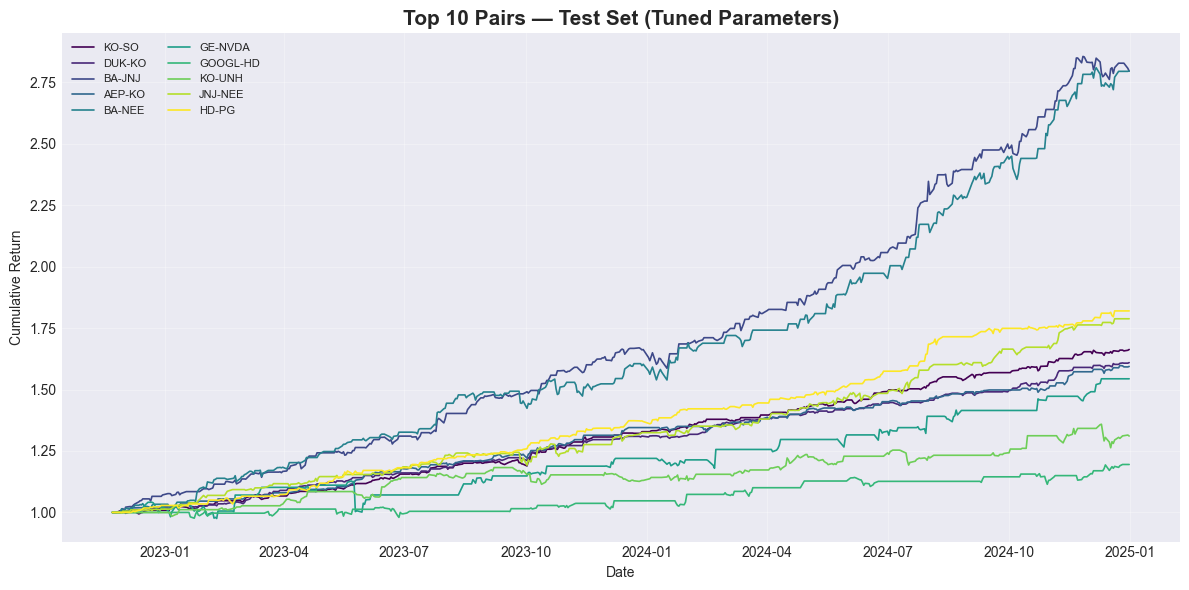

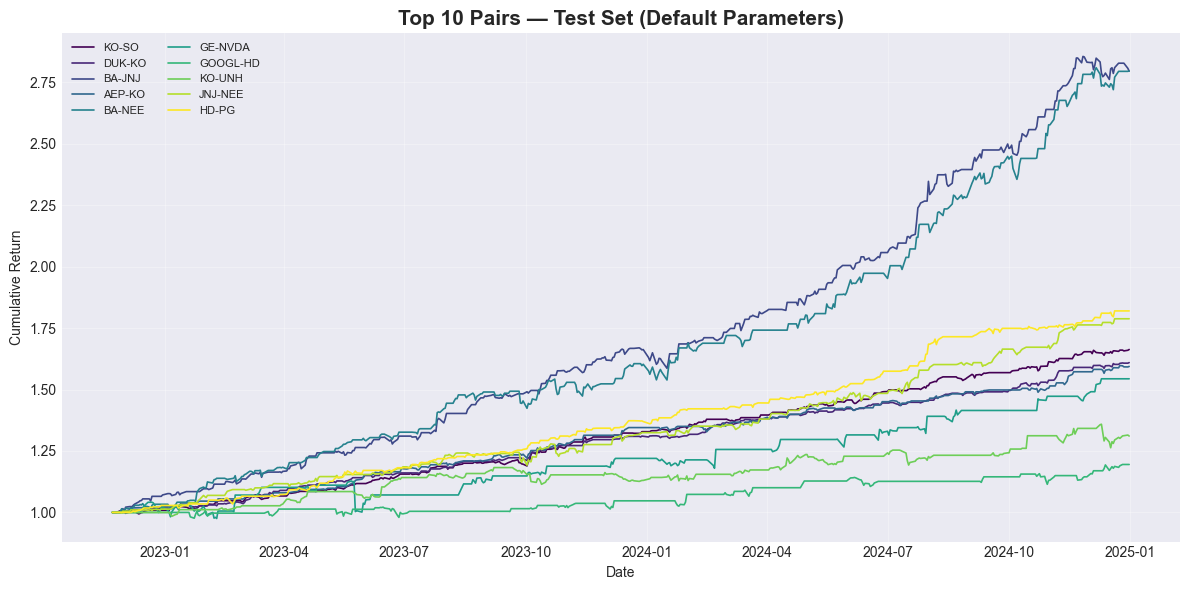

In [154]:

#helper function to get returns from the run_pair_pipeline function only for the test data set
def get_returns_for_plot(top_pairs, tuned=True):
    results = {}

    for (a, b, _) in top_pairs:
        pair_name = f"{a}-{b}"
        res = run_pair_pipeline((a, b), start, end)  # only test data
        bt_df = res['bt_test']
        results[pair_name] = bt_df['cumulative_return']

    return results

def plot_test_curves(data_dict, title):
    plt.figure(figsize=(12, 6))

    cmap = plt.get_cmap("viridis")
    colors = [cmap(i) for i in np.linspace(0, 1, len(data_dict))]

    for (pair_name, series), color in zip(data_dict.items(), colors):
        plt.plot(series.index, series.values, 
                 linewidth=1.2, 
                 label=pair_name, 
                 color=color)

    plt.title(title, fontsize=15, weight='bold')
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper left", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

test_tuned = get_returns_for_plot(top_pairs, tuned=True)
test_default = get_returns_for_plot(top_pairs, tuned=False)

plot_test_curves(test_tuned,   "Top 10 Pairs — Test Set (Tuned Parameters)")
plot_test_curves(test_default, "Top 10 Pairs — Test Set (Default Parameters)")



